In [1]:
# pytorch
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os

# torchsummary for easy checking and debugging
from torchsummary import summary

# torchvision for downloading and processing dataset
import torchvision
from torchvision import transforms
from torchvision.datasets import FashionMNIST

# others for notebook UI and latent space visualization
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Checking is CUDA available on current machine
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Project running on device: ", DEVICE)

# configurations for the task
config = {
    "batch_size": 64,
    "epochs": 1000,
    "lr": 5e-4,   # learning rate
}

Project running on device:  cuda


In [2]:
# This function convert the PIL images to tensors then pad them
def collate_fn(batch):
    process = transforms.Compose([
                transforms.ToTensor(),
                transforms.Pad([2])]
                )
 
    # x - images; we process each image in the batch
    x = [process(data[0]) for data in batch]
    x = torch.concat(x).unsqueeze(1)
    
    # y - labels, note that we should convert the labels to LongTensor
    y = torch.LongTensor([data[1] for data in batch])

    return x, y

In [3]:
labels = ["T-shirt/top", 
          "Trouser", 
          "Pullover", 
          "Dress", 
          "Coat", 
          "Sandla", 
          "Shirt", 
          "Sneaker", 
          "Bag", 
          "Ankle boot"]

# download/load dataset
train_data = FashionMNIST("./MNIST_DATA", train=True, download=True)
valid_data = FashionMNIST("./MNIST_DATA", train=False, download=True)

# put datasets into dataloaders
train_loader = DataLoader(train_data, batch_size=config["batch_size"], 
                          shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=config["batch_size"], 
                           shuffle=False, collate_fn=collate_fn)

Inspecting train data: 
Batch shape:  torch.Size([64, 1, 32, 32])


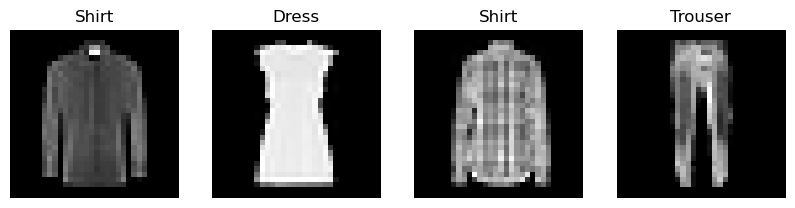

In [4]:
print("Inspecting train data: ")
for _, data in enumerate(train_loader):
    print("Batch shape: ", data[0].shape)
    fig, ax = plt.subplots(1, 4, figsize=(10, 4))

    for i in range(4):
        # Ture 3D tensor to 2D tensor due to image's single channel
        ax[i].imshow(data[0][i].squeeze(), cmap="gray")
        ax[i].axis("off")
        ax[i].set_title(labels[data[1][i]])
    plt.show()
    # And don't forget to break
    break

In [5]:
# Model parameters:
LAYERS = 3
KERNELS = [3, 3, 3]
CHANNELS = [32, 64, 128]
STRIDES = [2, 2, 2]
LINEAR_DIM = 2048

In [6]:
class Encoder(nn.Module):
    
    def __init__(self, output_dim=2, use_batchnorm=False, use_dropout=False):
        super(Encoder, self).__init__()
        
        # bottleneck dimentionality
        self.output_dim = output_dim

        # variables deciding if using dropout and batchnorm in model
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm
    
        # convolutional layer hyper parameters
        self.layers = LAYERS
        self.kernels = KERNELS
        self.channels = CHANNELS
        self.strides = STRIDES
        self.conv = self.get_convs()
        
        # layers for latent space projection
        self.fc_dim = LINEAR_DIM
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(self.fc_dim, self.output_dim)
    
    
    def get_convs(self):
        """
        generating convolutional layers based on model's 
        hyper parameters
        """
        conv_layers = nn.Sequential()
        for i in range(self.layers):
            # The input channel of the first layer is 1
            if i == 0: conv_layers.append(nn.Conv2d(1, 
                                              self.channels[i], 
                                              kernel_size=self.kernels[i],
                                              stride=self.strides[i],
                                              padding=1))
            
            else: conv_layers.append(nn.Conv2d(self.channels[i-1], 
                                         self.channels[i],
                                         kernel_size=self.kernels[i],
                                         stride=self.strides[i],
                                         padding=1))
            
            if self.use_batchnorm:
                conv_layers.append(nn.BatchNorm2d(self.channels[i]))
            
            # Here we use GELU as activation function
            conv_layers.append(nn.GELU()) 
            
            if self.use_dropout:
                conv_layers.append(nn.Dropout2d(0.15))

        return conv_layers
    
    
    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        return self.linear(x)

In [7]:
class Decoder(nn.Module):
    
    def __init__(self, input_dim=2, use_batchnorm=False, use_dropout=False):
        
        super(Decoder, self).__init__()
        
        # variables deciding if using dropout and batchnorm in model
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm

        self.fc_dim = LINEAR_DIM
        self.input_dim = input_dim
        
        # Conv layer hypyer parameters
        self.layers = LAYERS
        self.kernels = KERNELS
        self.channels = CHANNELS[::-1] # flip the channel dimensions
        self.strides = STRIDES
        
        # In decoder, we first do fc project, then conv layers
        self.linear = nn.Linear(self.input_dim, self.fc_dim)
        self.conv =  self.get_convs()

        self.output = nn.Conv2d(self.channels[-1], 1, kernel_size=1, stride=1)

    def get_convs(self):
        conv_layers = nn.Sequential()
        for i in range(self.layers):
            
            if i == 0: conv_layers.append(
                            nn.ConvTranspose2d(self.channels[i],
                                               self.channels[i],
                                               kernel_size=self.kernels[i],
                                               stride=self.strides[i],
                                               padding=1,
                                               output_padding=1)
                            )
            
            else: conv_layers.append(
                            nn.ConvTranspose2d(self.channels[i-1], 
                                               self.channels[i],
                                               kernel_size=self.kernels[i],
                                               stride=self.strides[i],
                                               padding=1,
                                               output_padding=1
                                              )
                            )
            
            if self.use_batchnorm and i != self.layers - 1:
                conv_layers.append(nn.BatchNorm2d(self.channels[i]))

            conv_layers.append(nn.GELU())

            if self.use_dropout:
                conv_layers.append(nn.Dropout2d(0.15))

        return conv_layers
    
    
    def forward(self, x):
        x = self.linear(x)
        # reshape 3D tensor to 4D tensor
        x = x.reshape(x.shape[0], 128, 4, 4)
        x = self.conv(x)
        return self.output(x)

In [8]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(output_dim=2, 
                               use_batchnorm=True, use_dropout=False)
        self.decoder = Decoder(input_dim=2,
                               use_batchnorm=True, use_dropout=False)
        
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [9]:
def plotting(step:int=0, show=False):
    
    model.eval() # Switch the model to evaluation mode
    
    points = []
    label_idcs = []
    
    path = "./ScatterPlots"
    if not os.path.exists(path): os.mkdir(path)
    
    for i, data in enumerate(valid_loader):
        img, label = [d.to(DEVICE) for d in data]
        # We only need to encode the validation images
        proj = model.encoder(img) # encoder(img)에서 수정
        points.extend(proj.detach().cpu().numpy())
        label_idcs.extend(label.detach().cpu().numpy())
        del img, label
    
    points = np.array(points)
    
    # Creating a scatter plot
    fig, ax = plt.subplots(figsize=(10, 10) if not show else (8, 8))
    scatter = ax.scatter(x=points[:, 0], y=points[:, 1], s=2.0, 
                c=label_idcs, cmap='tab10', alpha=0.9, zorder=2)
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    if show: 
        ax.grid(True, color="lightgray", alpha=1.0, zorder=0)
        plt.show()
    else: 
        # Do not show but only save the plot in training
        plt.savefig(f"{path}/Step_{step:03d}.png", bbox_inches="tight")
        plt.close() # don't forget to close the plot, or it is always in memory
        model.train()

# convert image sequence to a gif file
def save_gif():
  
  frames = []
  imgs = sorted(os.listdir("./ScatterPlots"))

  for im in imgs:
      new_frame = Image.open("./ScatterPlots/" + im)
      frames.append(new_frame)
  
  frames[0].save("latentspace.gif", format="GIF",
                 append_images=frames[1:],
                 save_all=True,
                 duration=200, loop=0)

In [10]:
# training
model=AutoEncoder()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=1e-5)

# For mixed precision training
scaler = torch.cuda.amp.GradScaler()
steps = 0 # tracking the training steps

In [11]:
def train(model, dataloader, criterion, optimizer, save_distrib=False):
    # steps is used to track training progress, purely for latent space plots
    global steps 
    
    model.to(DEVICE)  # 모델을 GPU로 이동
    model.train()
    train_loss = 0.0
    
    # Process tqdm bar, helpful for monitoring training process
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, 
                     leave=False, position=0, desc="Train")

    for i, batch in enumerate(dataloader):
        
        optimizer.zero_grad()
        x = batch[0].to(DEVICE)
        x = x.float()
        # Here we implement the mixed precision training
        y_recons = model(x)
        with torch.cuda.amp.autocast():
            loss = criterion(y_recons, x)
        
        train_loss += loss.item()
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        batch_bar.set_postfix(
            loss=f"{train_loss/(i+1):.4f}",
            lr = f"{optimizer.param_groups[0]['lr']:.4f}"
        )
        batch_bar.update()        

        # Saving latent space plots
        if steps % 10 == 0 and save_distrib: plotting(steps) # and steps <= 400:
        steps += 1        
        
        # remove unnecessary cache in CUDA memory
        torch.cuda.empty_cache()
        del x, y_recons
    
    batch_bar.close()
    train_loss /= len(dataloader)

    return train_loss

In [12]:
def validate(model, dataloader, criterion):
    
    model.eval() # Don't forget to turn the model to eval mode
    valid_loss = 0.0
    
    # Progress tqdm bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True,
                     leave=False, position=0, desc="Validation")
    
    for i, batch in enumerate(dataloader):
        x = batch[0].to(DEVICE)
        
        with torch.no_grad(): # we don't need gradients in validation
            y_recons = model(x)
            loss = criterion(y_recons, x)
        
        valid_loss += loss.item()
        
        batch_bar.set_postfix(
            loss=f"{valid_loss/(i+1):.4f}",
            lr = f"{optimizer.param_groups[0]['lr']:.4f}"
        )
        batch_bar.update()
        
        torch.cuda.empty_cache()
        del x, y_recons
    
    batch_bar.close()
    valid_loss /= len(dataloader)
    
    return valid_loss

In [13]:
for i in range(config["epochs"]):

    curr_lr = float(optimizer.param_groups[0]["lr"])
    train_loss = train(model, train_loader, criterion, 
                       optimizer, save_distrib=True)
    valid_loss = validate(model, valid_loader, criterion)

    print(f"Epoch {i+1}/{config['epochs']}\nTrain loss: {train_loss:.4f}\t Validation loss: {valid_loss:.4f}\tlr: {curr_lr:.4f}")


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/1000
Train loss: 0.0281	 Validation loss: 0.0252	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/1000
Train loss: 0.0244	 Validation loss: 0.0233	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/1000
Train loss: 0.0233	 Validation loss: 0.0228	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/1000
Train loss: 0.0226	 Validation loss: 0.0225	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/1000
Train loss: 0.0222	 Validation loss: 0.0218	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/1000
Train loss: 0.0219	 Validation loss: 0.0218	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/1000
Train loss: 0.0216	 Validation loss: 0.0215	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/1000
Train loss: 0.0214	 Validation loss: 0.0215	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/1000
Train loss: 0.0212	 Validation loss: 0.0213	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/1000
Train loss: 0.0211	 Validation loss: 0.0211	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11/1000
Train loss: 0.0210	 Validation loss: 0.0209	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12/1000
Train loss: 0.0208	 Validation loss: 0.0209	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13/1000
Train loss: 0.0207	 Validation loss: 0.0208	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14/1000
Train loss: 0.0206	 Validation loss: 0.0207	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15/1000
Train loss: 0.0205	 Validation loss: 0.0209	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16/1000
Train loss: 0.0205	 Validation loss: 0.0206	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17/1000
Train loss: 0.0204	 Validation loss: 0.0207	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18/1000
Train loss: 0.0203	 Validation loss: 0.0207	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19/1000
Train loss: 0.0203	 Validation loss: 0.0205	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20/1000
Train loss: 0.0202	 Validation loss: 0.0205	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 21/1000
Train loss: 0.0201	 Validation loss: 0.0204	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 22/1000
Train loss: 0.0200	 Validation loss: 0.0203	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 23/1000
Train loss: 0.0200	 Validation loss: 0.0204	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 24/1000
Train loss: 0.0199	 Validation loss: 0.0203	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 25/1000
Train loss: 0.0199	 Validation loss: 0.0203	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 26/1000
Train loss: 0.0198	 Validation loss: 0.0203	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 27/1000
Train loss: 0.0198	 Validation loss: 0.0203	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 28/1000
Train loss: 0.0198	 Validation loss: 0.0202	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 29/1000
Train loss: 0.0197	 Validation loss: 0.0202	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 30/1000
Train loss: 0.0197	 Validation loss: 0.0203	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 31/1000
Train loss: 0.0196	 Validation loss: 0.0202	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 32/1000
Train loss: 0.0196	 Validation loss: 0.0202	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 33/1000
Train loss: 0.0196	 Validation loss: 0.0202	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 34/1000
Train loss: 0.0196	 Validation loss: 0.0202	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 35/1000
Train loss: 0.0195	 Validation loss: 0.0202	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 36/1000
Train loss: 0.0195	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 37/1000
Train loss: 0.0194	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 38/1000
Train loss: 0.0194	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 39/1000
Train loss: 0.0194	 Validation loss: 0.0202	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 40/1000
Train loss: 0.0194	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 41/1000
Train loss: 0.0193	 Validation loss: 0.0202	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 42/1000
Train loss: 0.0193	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 43/1000
Train loss: 0.0193	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 44/1000
Train loss: 0.0192	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 45/1000
Train loss: 0.0192	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 46/1000
Train loss: 0.0192	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 47/1000
Train loss: 0.0192	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 48/1000
Train loss: 0.0191	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 49/1000
Train loss: 0.0191	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 50/1000
Train loss: 0.0191	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 51/1000
Train loss: 0.0191	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 52/1000
Train loss: 0.0190	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 53/1000
Train loss: 0.0190	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 54/1000
Train loss: 0.0190	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 55/1000
Train loss: 0.0190	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 56/1000
Train loss: 0.0190	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 57/1000
Train loss: 0.0190	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 58/1000
Train loss: 0.0189	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 59/1000
Train loss: 0.0189	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 60/1000
Train loss: 0.0189	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 61/1000
Train loss: 0.0189	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 62/1000
Train loss: 0.0189	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 63/1000
Train loss: 0.0188	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 64/1000
Train loss: 0.0188	 Validation loss: 0.0199	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 65/1000
Train loss: 0.0188	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 66/1000
Train loss: 0.0188	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 67/1000
Train loss: 0.0188	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 68/1000
Train loss: 0.0188	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 69/1000
Train loss: 0.0187	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 70/1000
Train loss: 0.0187	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 71/1000
Train loss: 0.0187	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 72/1000
Train loss: 0.0187	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 73/1000
Train loss: 0.0187	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 74/1000
Train loss: 0.0187	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 75/1000
Train loss: 0.0186	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 76/1000
Train loss: 0.0186	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 77/1000
Train loss: 0.0186	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 78/1000
Train loss: 0.0186	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 79/1000
Train loss: 0.0186	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 80/1000
Train loss: 0.0186	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 81/1000
Train loss: 0.0186	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 82/1000
Train loss: 0.0186	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 83/1000
Train loss: 0.0185	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 84/1000
Train loss: 0.0185	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 85/1000
Train loss: 0.0185	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 86/1000
Train loss: 0.0185	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 87/1000
Train loss: 0.0185	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 88/1000
Train loss: 0.0185	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 89/1000
Train loss: 0.0185	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 90/1000
Train loss: 0.0184	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 91/1000
Train loss: 0.0184	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 92/1000
Train loss: 0.0185	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 93/1000
Train loss: 0.0184	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 94/1000
Train loss: 0.0184	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 95/1000
Train loss: 0.0184	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 96/1000
Train loss: 0.0184	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 97/1000
Train loss: 0.0184	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 98/1000
Train loss: 0.0184	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 99/1000
Train loss: 0.0184	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 100/1000
Train loss: 0.0183	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 101/1000
Train loss: 0.0183	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 102/1000
Train loss: 0.0183	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 103/1000
Train loss: 0.0183	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 104/1000
Train loss: 0.0183	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 105/1000
Train loss: 0.0183	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 106/1000
Train loss: 0.0183	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 107/1000
Train loss: 0.0183	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 108/1000
Train loss: 0.0183	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 109/1000
Train loss: 0.0183	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 110/1000
Train loss: 0.0183	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 111/1000
Train loss: 0.0183	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 112/1000
Train loss: 0.0182	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 113/1000
Train loss: 0.0182	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 114/1000
Train loss: 0.0182	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 115/1000
Train loss: 0.0182	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 116/1000
Train loss: 0.0182	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 117/1000
Train loss: 0.0182	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 118/1000
Train loss: 0.0182	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 119/1000
Train loss: 0.0182	 Validation loss: 0.0200	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 120/1000
Train loss: 0.0182	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 121/1000
Train loss: 0.0182	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 122/1000
Train loss: 0.0182	 Validation loss: 0.0201	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
import imageio
import os

# PNG 파일이 있는 폴더 경로
folder_path = r"C:\Users\User\Desktop\스터디\DeepLearning_prac\personal practice\ScatterPlots"

# 폴더 내 PNG 파일 목록 추출
filenames = []
for filename in os.listdir(folder_path):
    if filename.endswith(".png"):
        filenames.append(os.path.join(folder_path, filename))

# 이미지 읽기
images = []
for filename in filenames:
    images.append(imageio.imread(filename))

# GIF 저장
imageio.imsave('my_animation.gif', images, format='GIF', duration=0.2)  # duration: 프레임 간격



C:\Users\User\AppData\Local\Temp\ipykernel_33100\3798303568.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
